In [94]:
#Import libraries

import numpy as np 
import pandas as pd
from statistics import mean
import matplotlib.pyplot as plt
import os

from intuitiveml.unsupervised.KMeans import *
from sklearn.datasets import make_blobs

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn import tree

from sklearn.model_selection import cross_val_score
from sklearn import svm

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from category_encoders import TargetEncoder

1. Collection

In [95]:
#Import databases

df_labels = pd.read_csv("train_labels.csv", sep=",")
df_values = pd.read_csv("train_values.csv", sep=",")
x_test = pd.read_csv("test_values.csv", sep=",")


In [96]:
df_labels.head(3)

,building_id,damage_grade
0,802906,3
1,28830,2
2,94947,3


In [97]:
df_values.head(2)

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,802906,6,487,12198,2,30,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0
1,28830,8,900,2812,2,10,8,7,o,r,...,0,0,0,0,0,0,0,0,0,0


In [98]:
#Merge the two dataframes into one

df = df_values.merge(df_labels, left_on='building_id', right_on='building_id')
df.head(3)

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,802906,6,487,12198,2,30,6,5,t,r,...,0,0,0,0,0,0,0,0,0,3
1,28830,8,900,2812,2,10,8,7,o,r,...,0,0,0,0,0,0,0,0,0,2
2,94947,21,363,8973,2,10,5,5,t,r,...,0,0,0,0,0,0,0,0,0,3


2. Cleaning

In [99]:
#Check duplicates - there are not duplicated values

df.duplicated().any()

False

In [100]:
#Check nulls - there are not nulls

df.isnull().sum().any()

False

In [101]:
#Drop rows/columns - there are some columns that describe if a building has a secondary use.
#I do not consider these columns very relevant to calculate the damage. I delete them.

df.columns


Index(['building_id', 'geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id',
       'count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage',
       'land_surface_condition', 'foundation_type', 'roof_type',
       'ground_floor_type', 'other_floor_type', 'position',
       'plan_configuration', 'has_superstructure_adobe_mud',
       'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
       'legal_ownership_status', 'count_families', 'has_secondary_use',
       'has_secondary_use_agriculture', 'has_secondary_use_hotel',
       'has_secondary_use_rental', 'has_secondary_use_institution',
       'has_secondary_use_school', 'has_secondary_use_i

In [102]:
# We drop the columns from both df and x_test

df.drop(["has_secondary_use", "has_secondary_use_agriculture", "has_secondary_use_hotel", "has_secondary_use_rental", "has_secondary_use_institution", "has_secondary_use_school", "has_secondary_use_industry",
"has_secondary_use_health_post", "has_secondary_use_gov_office", "has_secondary_use_use_police", "has_secondary_use_other"], axis = 1, inplace = True)  

x_test.drop(["has_secondary_use", "has_secondary_use_agriculture", "has_secondary_use_hotel", "has_secondary_use_rental", "has_secondary_use_institution", "has_secondary_use_school", "has_secondary_use_industry",
"has_secondary_use_health_post", "has_secondary_use_gov_office", "has_secondary_use_use_police", "has_secondary_use_other"], axis = 1, inplace = True)  

In [103]:
#The variables geo_level_1_id, geo_level_2_id, geo_level_3_id are integer but they relate to different locations.
#It makes more sense to change their type to category

In [104]:
df['geo_level_1_id'] = pd.Categorical(df.geo_level_1_id)
df['geo_level_2_id'] = pd.Categorical(df.geo_level_2_id)
df['geo_level_3_id'] = pd.Categorical(df.geo_level_3_id)


In [105]:
#I do the same on the x_test dataset

x_test['geo_level_1_id'] = pd.Categorical(x_test.geo_level_1_id)
x_test['geo_level_2_id'] = pd.Categorical(x_test.geo_level_2_id)
x_test['geo_level_3_id'] = pd.Categorical(x_test.geo_level_3_id)

In [106]:
#Outliers


#The numeric variables are:

#count_floors_pre_eq, age, area_percentage, height_percentage, count_families

<AxesSubplot:ylabel='Frequency'>

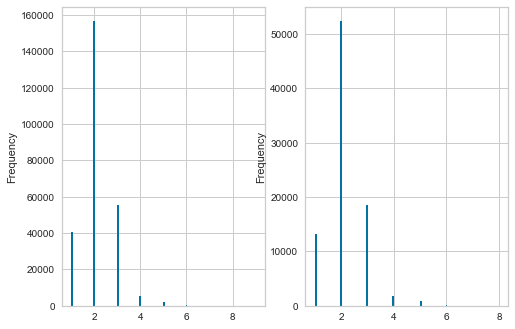

In [107]:
#count_floors_pre_eq - no outliers
plt.subplot(1,2,1)
df['count_floors_pre_eq'].plot(kind='hist', bins = 100)
plt.subplot(1,2,2)
x_test['count_floors_pre_eq'].plot(kind='hist', bins = 100)

<AxesSubplot:ylabel='Frequency'>

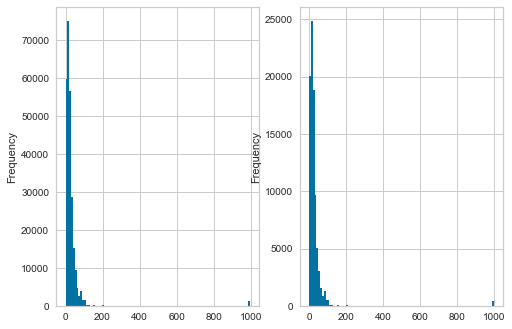

In [108]:
#There is an outlier in the age, we delete it

plt.subplot(1,2,1)
df['age'].plot(kind='hist', bins = 100)
plt.subplot(1,2,2)
x_test['age'].plot(kind='hist', bins = 100)


In [109]:
#mean = df.loc[df['age']<500, 'age'].mean()
#df.loc[df.age > 500, 'age'] = np.nan
#df['age'].fillna(mean,inplace=True)

In [110]:
#mean = x_test.loc[x_test['age']<500, 'age'].mean()
#x_test.loc[x_test.age > 500, 'age'] = np.nan
#x_test['age'].fillna(mean,inplace=True)

<AxesSubplot:ylabel='Frequency'>

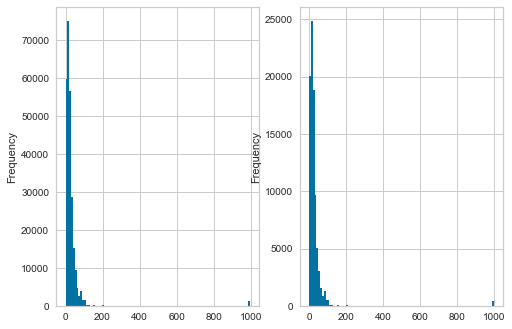

In [111]:
plt.subplot(1,2,1)
df['age'].plot(kind='hist', bins = 100)
plt.subplot(1,2,2)
x_test['age'].plot(kind='hist', bins = 100)

<AxesSubplot:ylabel='Frequency'>

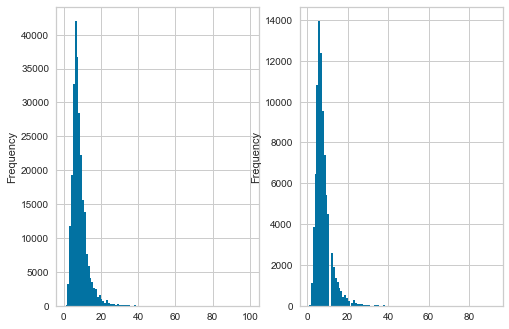

In [112]:
#area_percentage - no outliers
plt.subplot(1,2,1)
df['area_percentage'].plot(kind='hist', bins = 100)
plt.subplot(1,2,2)
x_test['area_percentage'].plot(kind='hist', bins = 100)

<AxesSubplot:ylabel='Frequency'>

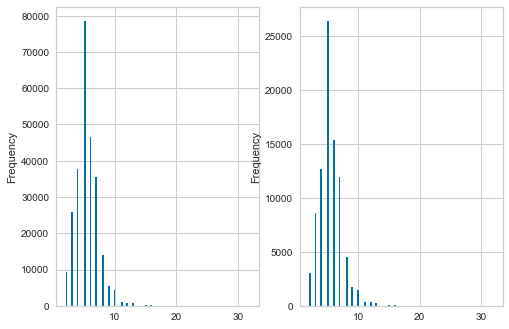

In [113]:
#height_percentage - no outliers
plt.subplot(1,2,1)
df['height_percentage'].plot(kind='hist', bins = 100)
plt.subplot(1,2,2)
x_test['height_percentage'].plot(kind='hist', bins = 100)

<AxesSubplot:ylabel='Frequency'>

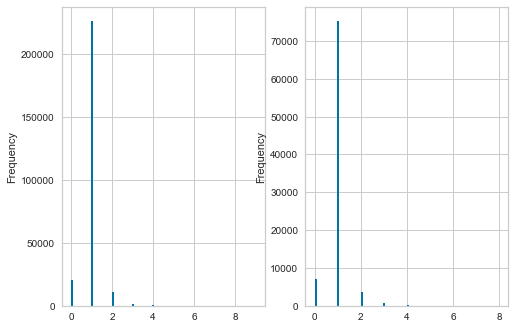

In [114]:
#count_families - no outliers
plt.subplot(1,2,1)
df['count_families'].plot(kind='hist', bins = 100)
plt.subplot(1,2,2)
x_test['count_families'].plot(kind='hist', bins = 100)

In [115]:
#Dealing with categorical variables

#geo_level_1_id
#geo_level_2_id
#geo_level_3_id
#land_surface_condition OHE
#foundation_type LE
#roof_type LE
#ground_floor_type LE
#other_floor_type LE
#position OHE
#plan_configuration LE
#legal_ownership_status OHE

In [116]:
#I create a list with all the categorical variables

cat_columns = ["geo_level_1_id", "geo_level_2_id", "geo_level_3_id", "land_surface_condition", "position", "legal_ownership_status", "foundation_type", "roof_type", "ground_floor_type", "other_floor_type", "plan_configuration"]


In [117]:
#Target Encoding for the categorical variables

X = df.drop("damage_grade",axis = "columns")
y = df["damage_grade"]

In [118]:
encoder = TargetEncoder()
tg_enc = encoder.fit(X, y)
Transformed_x_train = tg_enc.transform(X)
Transformed_x_test = tg_enc.transform(x_test)

c:\Users\alfre\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning:

Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327

c:\Users\alfre\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning:

Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327



In [119]:
#String cleaning-there are no string variables

In [120]:
#Scaling- there are no variables that I think they should be scaled

3. Grid Search CV


In [121]:
# Load GridSearchCV from Sklearn and test the following hyper-parameters
intercept = [True, False]
alpha = [1e-2, 1e-1, 1, 1e1]
max_iter = [5000]

In [122]:
# Which hyper-parameters get us the best results using MSE as scoring?


param_grid = {
    'alpha': alpha,
    'fit_intercept': intercept,
    "max_iter": max_iter
}
scoring = "neg_mean_squared_error"

In [123]:
gscv = GridSearchCV(
    estimator = Lasso(),
    param_grid = param_grid,
    scoring = scoring
)
fitted_gscv = gscv.fit(Transformed_x_train, y)
cv_results = fitted_gscv.cv_results_

In [124]:
fitted_gscv.best_params_

{'alpha': 0.01, 'fit_intercept': True, 'max_iter': 5000}

4. Model Building

In [125]:
#We are going to use a 

In [126]:
#X and y(target) selection

X = df.drop("damage_grade", axis = "columns")
y = df["damage_grade"]


4. Model selection

Tree

In [133]:

#initialize the decisiontreeclassifier- we take the initializated functions from above


rfc_gg = RandomForestClassifier(criterion = "gini", min_samples_split=20, n_estimators=200)

rfc_scores_gg = cross_val_score(rfc_gg, Transformed_x_train, y, cv = 5, scoring = "f1_micro")

print("random forest gini f1 score is on average", mean(rfc_scores_gg))

random forest gini f1 score is on average 0.75424115843965


In [139]:
from sklearn.preprocessing import MinMaxScaler

rfc_gg = RandomForestClassifier(criterion = "gini", min_samples_split=20, n_estimators=200)

scaler = MinMaxScaler()
scaler.fit(Transformed_x_train)
new_x=scaler.transform(Transformed_x_train)
new_x_test=scaler.transform(Transformed_x_test)

In [140]:
#fit the model

rfc_gg.fit(new_x,y)


RandomForestClassifier(min_samples_split=20, n_estimators=200)

In [141]:
#y_test creation

y_test = rfc_gg.predict(new_x_test)

5. Visualization

6. Creating Submitting File

In [142]:
#I change y_test to the submission format 

sub = pd.DataFrame(y_test, columns = ['damage_grade'], index = x_test.building_id)
sub.index = sub.index.rename("building_id")
sub

,damage_grade
building_id,
300051,3
99355,2
890251,3
745817,1
421793,3
...,...
310028,2
663567,3
1049160,2


In [143]:
#Submission file

if os.path.exists("submission.csv"):
    os.remove("submission.csv")
    sub.to_csv("submission.csv", sep=',')
else:
    sub.to_csv("submission.csv", sep=',')
